In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from Data.Featurisation import data_handeler
import numpy as np
import scienceplots
import torch
from scale import Scale
from hyperparameters.hyperparameters import hyperparameters_source
from Models.lstm import LSTM
from tensors.Tensorisation import Tensorisation
plt.rcdefaults()
plt.style.use(['science'])
avg_rmse = pd.read_pickle("evaluation/Target/avg_rmse.pkl")
avg_times = pd.read_pickle("evaluation/Target/avg_times.pkl")
rmse = pd.read_pickle("evaluation/Target/rmse.pkl")
time = pd.read_pickle("evaluation/Target/times.pkl")
time = time.loc[:,(slice(None), 'Training Time')]
sites = range(9)
models = [0,1,5,6,2,3,4,8,9]
model_labels = [r"$\text{Transf}_{np}$", r"$\text{Transf}_{p}$", r"$\text{Transf}_{nw}$",r"$\text{Targ}_{np}$", r"$\text{Targ}_{p}$",r"$\text{Transf}_{ra,np}$",
                 r"$\text{Transf}_{ra,p}$", "niks", "Phys", "Persis"]
sites_list = [r"$\text{NL}_1$",r"$\text{NL}_2$", "CR", "UK", r"$\text{NL}_3$",r"$\text{NL}_4$",r"$\text{NL}_5$",r"$\text{NL}_6$",r"$\text{NL}_7$"]

import itertools



In [ ]:
#AVG RMSE
from pvlib import location
avg_rmse = pd.DataFrame(index=models, columns=sites)
avg_mae = pd.DataFrame(index=models, columns=sites)
month_rmse = pd.DataFrame()
month_rmse = month_rmse.reindex(rmse.index)
print(month_rmse)
metadata = pd.read_pickle("Data/Sites/metadata.pkl")
for site in sites:
    print(site)
    lat = metadata.loc[site, "Latitude"]
    lon = metadata.loc[site, "Longitude"]
    _,_, eval_data = data_handeler(site, "nwp", "nwp", "nwp", transform=False)
    
    
    for model in models:  
        with open(f"DA_forecasts/DA_{model}_{site}", 'rb') as f:
            DA_forecast = pickle.load(f)
        
        power = eval_data['P']
        DA_forecast = DA_forecast[:] #(30 days + 1 lag day)*24
        power = power[24:] ###CHANGE BACK TO  31
        substr = DA_forecast-power
        times = substr.index
        loc = location.Location(lat, lon)
        
        sol_pos = loc.get_solarposition(times)
        zenith_filter = sol_pos["zenith"] < 85
        substr_month = substr**2
        periods = pd.Series([i//(30*24) for i in range(len(substr_month.index))], index=substr_month.index)
        substr_month = substr_month[zenith_filter]
        substr_month = substr_month.groupby(periods).mean()
        substr_month = np.sqrt(substr_month)
        substr = substr[30*24:] ##First month not of importance for average rmse
        avg_rmse.loc[model, site] = np.sqrt(np.mean(np.square(substr[zenith_filter])))
        avg_mae.loc[model, site] = np.mean(np.abs(substr[zenith_filter]))
        month_rmse.loc[(site, slice(0,periods.max())), model] = substr_month.values
    

## Zero-shot accuracy

In [5]:
zero_shot_rmse = month_rmse.loc[(slice(None), 0), :]
zero_shot_rmse = zero_shot_rmse.droplevel(1)
zero_shot_rmse.astype(float).round(2)


,0,1,5,6,2,3,4,8,9
one,,,,,,,,,
0,306.41,304.34,367.87,361.58,432.41,1385.47,1369.00,393.34,452.47
1,249.14,290.50,339.98,331.94,347.54,1202.70,1163.94,317.69,413.03
2,774.10,785.25,789.17,811.04,788.78,1762.11,1775.19,1336.48,950.90
3,327.67,293.64,344.37,364.96,339.65,738.92,735.23,407.28,330.46
4,266.19,272.29,314.18,308.27,383.77,1279.85,1247.27,359.22,430.01
5,266.42,231.25,287.48,289.21,345.20,1132.12,1108.12,299.30,367.85
6,247.19,249.51,288.06,288.46,360.56,1040.03,1031.42,347.93,396.69
7,261.48,260.00,241.09,251.87,387.60,1081.61,1035.62,281.32,428.59
8,281.80,287.90,300.34,298.47,347.73,1007.96,996.36,423.46,382.05


In [6]:
(1-zero_shot_rmse.div(zero_shot_rmse[9], axis=0)).astype(float).round(4)

,0,1,5,6,2,3,4,8,9
one,,,,,,,,,
0,0.3228,0.3274,0.1870,0.2009,0.0444,-2.0620,-2.0256,0.1307,0.0
1,0.3968,0.2967,0.1769,0.1963,0.1586,-1.9119,-1.8180,0.2308,0.0
2,0.1859,0.1742,0.1701,0.1471,0.1705,-0.8531,-0.8669,-0.4055,0.0
3,0.0085,0.1114,-0.0421,-0.1044,-0.0278,-1.2360,-1.2249,-0.2324,0.0
4,0.3810,0.3668,0.2694,0.2831,0.1075,-1.9763,-1.9006,0.1646,0.0
5,0.2758,0.3714,0.2185,0.2138,0.0616,-2.0776,-2.0124,0.1864,0.0
6,0.3769,0.3710,0.2739,0.2728,0.0911,-1.6218,-1.6001,0.1229,0.0
7,0.3899,0.3934,0.4375,0.4123,0.0956,-1.5236,-1.4163,0.3436,0.0
8,0.2624,0.2464,0.2139,0.2188,0.0898,-1.6383,-1.6079,-0.1084,0.0


## RMSE target

In [64]:
print(avg_rmse.astype(float).round(2).transpose())

        0       1       5       6       2       3       4        8        9
0  314.13  317.48  315.49  315.39  461.52  355.86  331.73   418.84   513.89
1  257.18  263.42  255.35  257.37  380.08  291.61  285.54   325.44   428.28
2  776.90  799.97  779.64  783.06  871.16  801.84  784.77  1279.13  1082.62
3  222.29  235.97  217.54  227.42  298.98  217.25  221.79   359.18   354.15
4  241.74  245.46  248.42  250.33  375.11  281.65  275.32   304.89   431.18
5  259.78  264.01  266.44  263.42  400.72  280.23  276.61   321.97   444.08
6  253.39  255.38  254.16  255.51  373.00  278.96  266.28   352.97   408.43
7  226.75  227.58  227.43  227.72  293.88  254.50  271.94   280.61   334.25
8  241.91  249.75  247.76  249.23  353.29  280.05  257.23   365.69   390.11


In [6]:
avg_skill_score = (1-avg_rmse/avg_rmse.loc[9]).astype(float).round(4).transpose()
avg_skill_score


,0,1,5,6,2,3,4,8,9
0,0.3887,0.3822,0.3861,0.3863,0.1019,0.3075,0.3545,0.1850,0.0
1,0.3995,0.3849,0.4038,0.3991,0.1125,0.3191,0.3333,0.2401,0.0
2,0.2824,0.2611,0.2799,0.2767,0.1953,0.2594,0.2751,-0.1815,0.0
3,0.3723,0.3337,0.3857,0.3579,0.1558,0.3866,0.3737,-0.0142,0.0
4,0.4393,0.4307,0.4239,0.4194,0.1300,0.3468,0.3615,0.2929,0.0
5,0.4150,0.4055,0.4000,0.4068,0.0976,0.3690,0.3771,0.2750,0.0
6,0.3796,0.3747,0.3777,0.3744,0.0867,0.3170,0.3480,0.1358,0.0
7,0.3216,0.3191,0.3196,0.3187,0.1208,0.2386,0.1864,0.1605,0.0
8,0.3799,0.3598,0.3649,0.3611,0.0944,0.2821,0.3406,0.0626,0.0


C:\Users\Robbe\AppData\Local\Temp\ipykernel_16536\3784934138.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_16536\3784934138.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_16536\3784934138.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_16536\3784934138.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


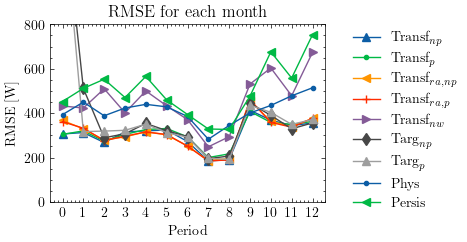

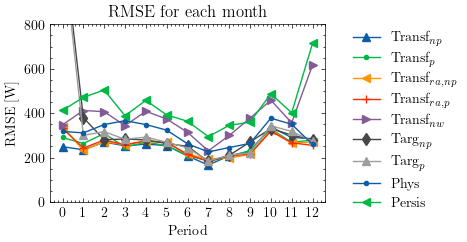

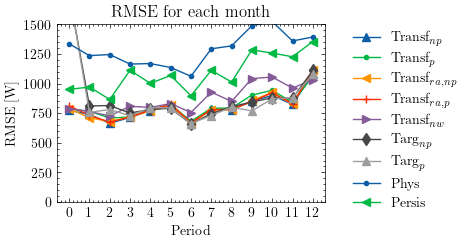

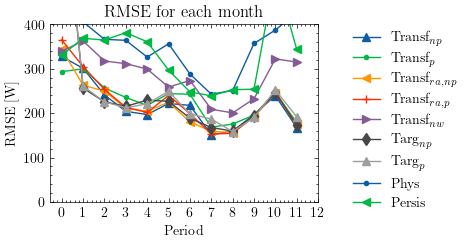

In [10]:
ymax = [800, 800, 1500, 400, 600,600,600,600,600]

for site in [0,1,2,3]:
    #RMSE
    marker = itertools.cycle(('^', '.', '<', '+', '>', 'd'))
    fig = plt.figure(site)
    for model in [0,1,5,6,2,3,4,8,9]:
        
        plt.plot(month_rmse.loc[(site, slice(None)), model].values, marker=next(marker), linestyle="-", label = model_labels[model])
    plt.ylim([0, ymax[site]])
    fig.legend(loc="center left", bbox_to_anchor=(1,0.5))
    plt.title("RMSE for each month")
    plt.xlabel("Period")
    plt.ylabel("RMSE [W]")
    plt.xticks(range(len(rmse.loc[site].index)), labels=range(len(rmse.loc[site].index)))
    plt.tight_layout()
    plt.savefig(f"Figures/evaluation/rmse_month_s{site}")
    fig.show()

## Time Target

C:\Users\Robbe\AppData\Local\Temp\ipykernel_16536\804497330.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_16536\804497330.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_16536\804497330.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_16536\804497330.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_16536\804497330.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_16536\804497330.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_16536\804497330.py:17: UserWarni

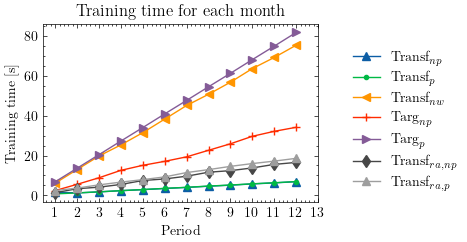

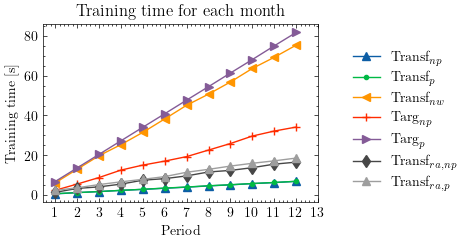

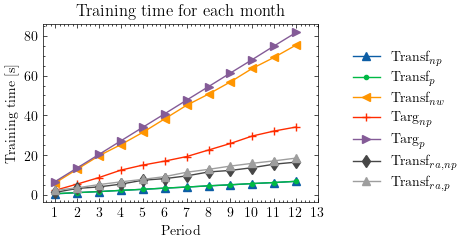

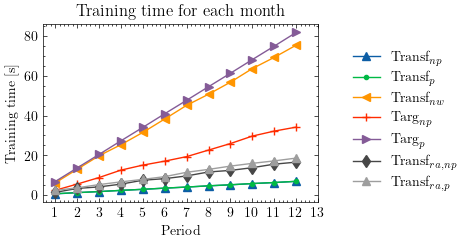

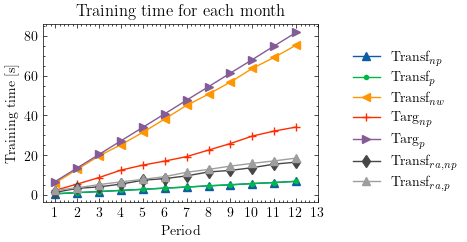

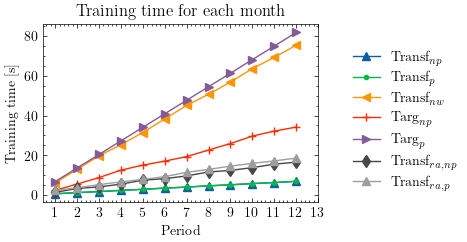

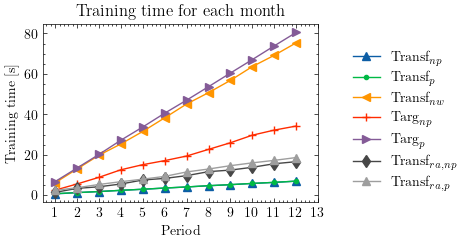

In [11]:
# ymax = [800, 800, 1200, 400]
for j, site in enumerate(sites):
    marker = itertools.cycle(('^', '.', '<', '+', '>', 'd'))
    #RMSE
    fig = plt.figure(site)
    for i, model in enumerate(models):
        if i <=6: 
            plt.plot(time.loc[(site, slice(None)), model].values, marker=next(marker), linestyle="-", label = model_labels[i])
    # plt.ylim([0, ymax[j]])
    fig.legend(loc="center left", bbox_to_anchor=(1,0.5))
    plt.xlabel("Period")
    plt.ylabel("Training time [s]")
    plt.title("Training time for each month")
    plt.xticks(range(len(rmse.loc[site].index)), labels=range(1,len(rmse.loc[site].index)+1))
    plt.tight_layout()
    plt.savefig(f"Figures/evaluation/time_month_{site}")
    fig.show()

In [24]:
training = avg_times.loc[:, (slice(None), 'Training Time')].droplevel(1, axis=1).transpose()
inference = avg_times.loc[:, (slice(None), 'Inference Time')].droplevel(1, axis=1).transpose()

training.mean(axis=1).astype(float).round(2)

one
0      3.75
1      3.77
2     43.82
3      9.06
4     10.41
5     40.87
6     18.62
7     18.79
8       NaN
9       NaN
10      NaN
11      NaN
dtype: float64

In [26]:
inference.mean(axis=1).astype(float).round(8)

one
0     0.000251
1     0.000144
2     0.000282
3     0.000253
4     0.000240
5     0.000244
6     0.000240
7     0.000237
8     0.022033
9     0.000013
10         NaN
11         NaN
dtype: float64

## Skill score target

C:\Users\Robbe\AppData\Local\Temp\ipykernel_16536\4096877425.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_16536\4096877425.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_16536\4096877425.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_16536\4096877425.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_16536\4096877425.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_16536\4096877425.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Robbe\AppData\Local\Temp\ipykernel_16536\4096877425.py:21: Us

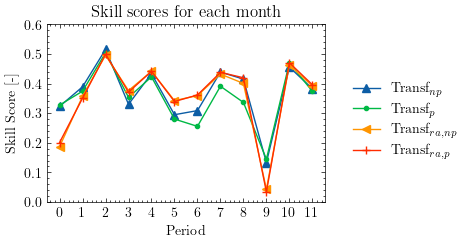

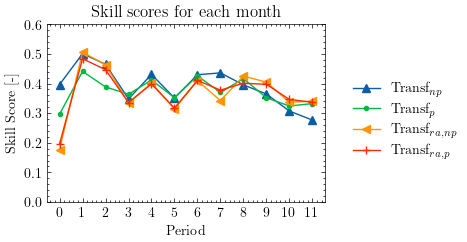

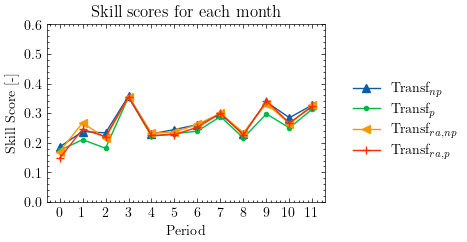

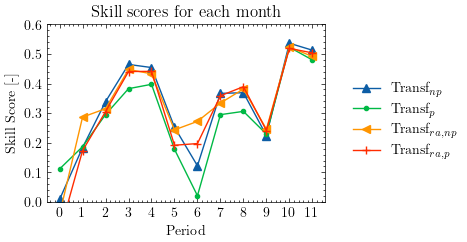

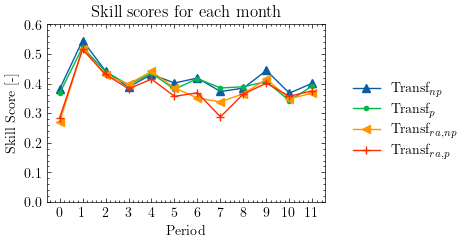

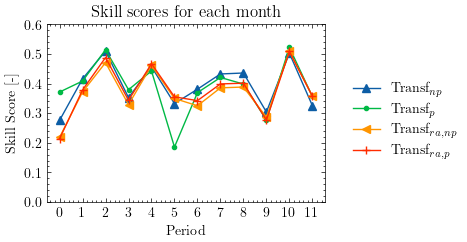

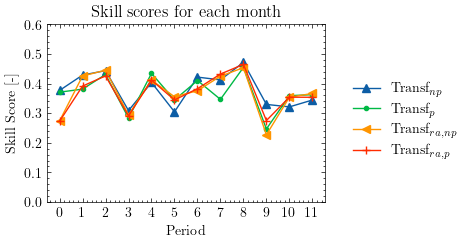

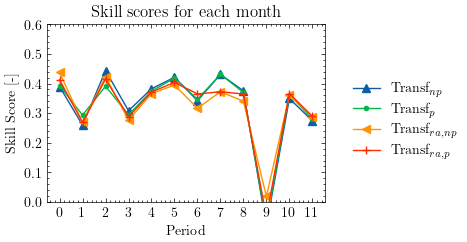

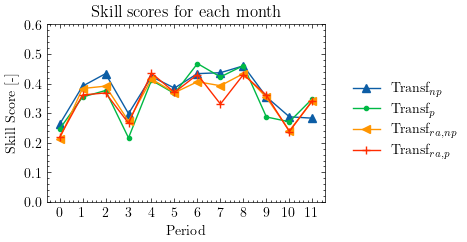

In [12]:
avg_skill_scores = pd.DataFrame(index=sites, columns=models)
for site in [0,1,2,3,4,5,6,7,8]:
    marker = itertools.cycle(('^', '.', '<', '+', '>', 'd'))
    persist = month_rmse.loc[(site, slice(None)), 9].values
    fig = plt.figure(site)
    for  model in [0,1,5,6]:
        if model != 9:
            rmse_mod_site = month_rmse.loc[(site, slice(None)), model].values
            ss = 1-  rmse_mod_site/persist
            ss= ss[:-1] #Dont select value for shorter month

            plt.plot(ss, marker=next(marker), linestyle="-", label = model_labels[model])
    plt.ylim([0, 0.6])
    fig.legend(loc="center left", bbox_to_anchor=(1,0.5))
    plt.xlabel("Period")
    plt.ylabel("Skill Score [-]")
    plt.title("Skill scores for each month")
    plt.xticks(range(len(rmse.loc[site].index)-1), labels=range(len(rmse.loc[site].index)-1))
    plt.tight_layout()
    plt.savefig(f"Figures/evaluation/ss_month_{site}")
    fig.show()

In [8]:
def calculate_skill_score(row):
    reference = row[9]
    skill_scores = {}
    for model in row.index[:-1]:  # Exclude the reference column
        model_rmse = row[model]
        skill_score = 1 - (model_rmse / reference)
        skill_scores[model] = skill_score
    return pd.Series(skill_scores)
rmse_NL = month_rmse.drop([2,3], level='two')
# Drop the last month
last_month = rmse_NL.index.get_level_values('two').max()
rmse_NL = rmse_NL.drop(last_month, level='two')
skill_scores = rmse_NL.apply(calculate_skill_score, axis=1)
skill_scores.reset_index(inplace=True)
skill_scores

,one,two,0,1,5,6,2,3,4,8
0,0,0,0.322810,0.327395,0.186976,0.200874,0.044353,-2.061994,-2.025588,0.130679
1,0,1,0.389139,0.374337,0.356901,0.350723,0.173136,0.000776,0.380542,0.120948
2,0,4,0.433430,0.422749,0.441294,0.441605,0.115399,0.374098,0.380441,0.222201
3,0,5,0.294807,0.280029,0.342366,0.339378,0.058121,0.301428,0.321208,0.068162
4,0,6,0.308676,0.255459,0.359599,0.361400,0.058040,0.251964,0.259975,0.021866
...,...,...,...,...,...,...,...,...,...,...
85,8,7,0.436724,0.422457,0.392766,0.330856,0.162647,0.398988,0.444201,0.324185
86,8,8,0.459941,0.460800,0.433779,0.430464,0.156208,0.452744,0.469959,0.340050
87,8,9,0.355143,0.287202,0.353245,0.360599,-0.029139,0.322315,0.313879,0.222709
88,8,10,0.287683,0.270904,0.240917,0.238002,0.061261,0.235728,0.241733,0.015568


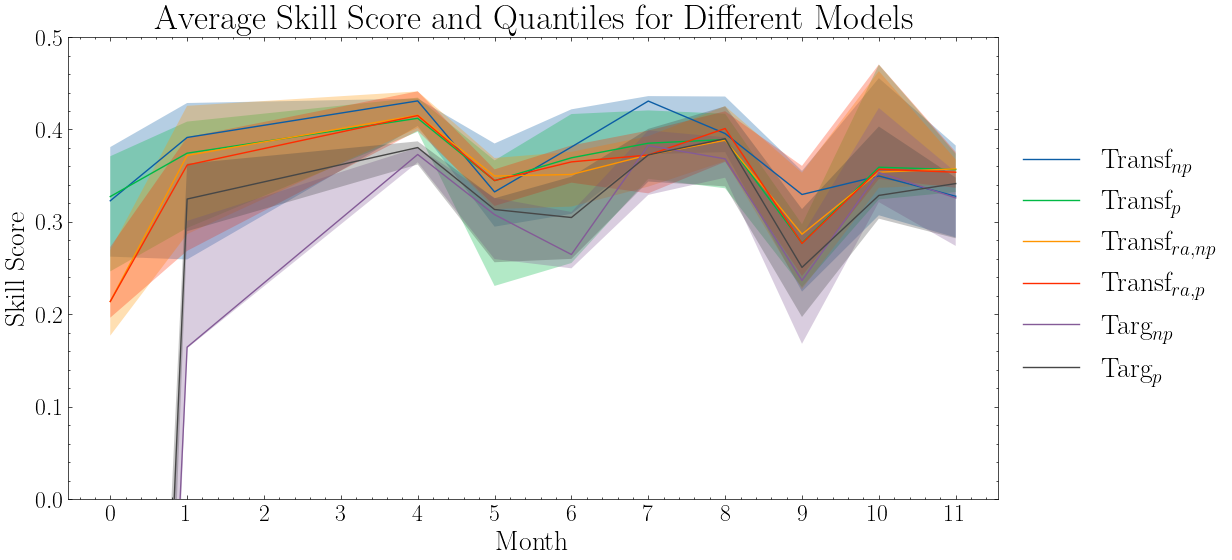

In [9]:
# Melt the DataFrame to long format for easier plotting with Seaborn
df_melted = skill_scores.melt(id_vars=['one', 'two'], var_name='Model', value_name='SkillScore')
# Calculate average and quantiles
summary = df_melted.groupby(['Model', 'two'])['SkillScore'].agg(median='median', q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)).reset_index()
# Plotting
plt.figure(figsize=(12, 6))
not_plot = [2,7,8,9,10]
models_plot = [x for x in models if x not in not_plot]
for i, model in enumerate(models_plot):
    model_data = summary[summary['Model'] == model]
    plt.plot(model_data['two'], model_data['median'], label=model_labels[model])
    plt.fill_between(model_data['two'], model_data['q25'], model_data['q75'], alpha=0.3)

plt.xlabel('Month', fontsize=20)
plt.ylabel('Skill Score', fontsize=20)
plt.ylim([0,0.5])
plt.title('Average Skill Score and Quantiles for Different Models', fontsize=25)
plt.legend(loc="center left", bbox_to_anchor=(1,0.5), fontsize=20)
plt.yticks(fontsize=17)
plt.xticks(range(len(rmse.loc[0].index)-1), labels=range(len(rmse.loc[0].index)-1), fontsize=17)
plt.savefig("Figures/evaluation/NL_aggr_ss", dpi=200)
plt.show()

### WFE MAE

In [91]:
avg_mae.astype(float).transpose().round(2)

,0,1,5,6,2,3,4,8,9
0,218.59,220.24,218.02,218.13,346.86,251.02,240.04,278.87,360.16
1,180.22,184.54,182.79,181.91,289.31,207.68,204.39,215.00,297.92
2,581.43,604.11,589.07,590.37,658.30,584.29,581.69,962.77,750.50
3,158.92,172.74,153.46,159.95,223.78,157.56,160.40,247.03,240.07
4,163.72,166.38,170.47,172.39,269.63,198.56,190.71,199.79,281.07
5,184.53,187.72,187.79,185.87,298.68,205.60,201.55,211.38,314.18
6,178.35,179.28,178.83,179.17,280.37,198.93,189.30,235.58,286.77
7,149.56,151.21,153.02,152.60,209.88,177.78,183.99,175.39,217.22
8,169.65,177.75,175.49,178.94,265.04,194.32,183.92,250.30,265.84


## Effect of finetuning

In [ ]:
for site in range(9):
    lat = metadata.loc[site, "Latitude"]
    lon = metadata.loc[site, "Longitude"]
    _,_,eval_data = data_handeler(site, "nwp", "nwp", "nwp", transform=False)
    with open("features/ft_no_phys.pkl", 'rb') as f:
        features = pickle.load(f)
    minmax = Scale()
    minmax.load(site, "nwp", False)
    tensors = Tensorisation(eval_data, 'P',features, 24, 24, train_test_split=1, domain_max=minmax.max, domain_min=minmax.min)
    x_train, x_test,y_train, y_test = tensors.tensor_creation()
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    hp = hyperparameters_source()
    hp.load(0)
    source_model = LSTM(7, hp.n_nodes, hp.n_layers, 24, hp.dropout)

    state_dict = torch.load(f"Models/source/nwp_{site}_no_phys.pkl", map_location=torch.device('cpu'))
    source_model.load_state_dict(state_dict)
    source_model.eval()
    with torch.inference_mode():
        forec = source_model(x_train)

    forec = forec.flatten().numpy() 
    y_train = y_train.flatten().numpy() 
    substr = pd.DataFrame({'P':(forec-y_train)*minmax.max['P']}, index=eval_data.iloc[24:].index)
    substr['period'] = [i//(24*30) for i in range(len(substr.index))]
    substr['P'] = substr['P']**2

    loc = location.Location(lat, lon)
    times = substr.index   
    sol_pos = loc.get_solarposition(times)
    zenith_filter = sol_pos["zenith"] < 85

    substr = substr[zenith_filter]
    month_rmse_source = substr.groupby('period').mean()
    month_rmse_source = np.sqrt(month_rmse_source) 
    month_rmse.loc[(site,slice(0,len(month_rmse_source.index)-1)), 10] = month_rmse_source.values


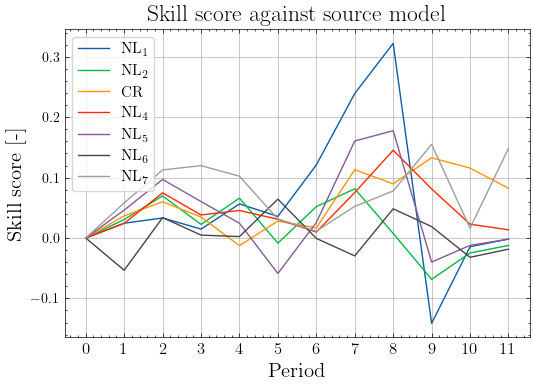

In [35]:
plt.figure(figsize = (6,4))
for site in [0,1,2,5,6,7,8]:
    model=0
    ss = 1-month_rmse.loc[(site,slice(None)), model]/month_rmse.loc[(site,slice(None)), 10]
    ss= ss[:-1]
    plt.plot(range(len(ss)), ss, label=sites_list[site])
plt.xticks(range(12), labels=range(12), fontsize=12)
plt.xlabel("Period", fontsize=15)
plt.ylabel("Skill score [-]", fontsize=15)
plt.title("Skill score against source model", fontsize=17)
plt.grid()
plt.legend(frameon=True, fontsize=11)
plt.savefig("Figures/evaluation/ss_source", dpi=200)

## Corr irradiance and performance

In [8]:
correl_matrix = pd.DataFrame()
sites = [0,1,4,5,6,7,8]
for site in sites:
    era5 = pd.read_pickle(f"Data/Sites/Reanalysis_{site}.pkl")
    nwp = pd.read_pickle(f"Data/Sites/NWP_{site}.pkl")
    meteo2CEDA = {'temperature_2m' :'temperature_1_5m', 
                "relative_humidity_2m":"relative_humidity_1_5m", 
                "pressure_msl": "pressure_MSL",
                "cloud_cover":"total_cloud_amount",
                "shortwave_radiation": "downward_surface_SW_flux",
                "diffuse_radiation":"diffuse_surface_SW_flux",
                "direct_normal_irradiance":"direct_surface_SW_flux",
                "wind_speed_10m": "wind_speed_10m",
                "wind_direction_10m": "wind_direction_10m"
                }
    era5 = era5.rename(columns=meteo2CEDA)
    irradiances = ["downward_surface_SW_flux"]
    for irrad in irradiances:
        correl_matrix.loc[site, irrad] = nwp[irrad].corr(era5[irrad])

In [65]:
avg_skill_score

,0,1,5,6,2,3,4,8,9
0,0.3887,0.3822,0.3861,0.3863,0.1019,0.3075,0.3545,0.1850,0.0
1,0.3995,0.3849,0.4038,0.3991,0.1125,0.3191,0.3333,0.2401,0.0
2,0.2824,0.2611,0.2799,0.2767,0.1953,0.2594,0.2751,-0.1815,0.0
3,0.3723,0.3337,0.3857,0.3579,0.1558,0.3866,0.3737,-0.0142,0.0
4,0.4393,0.4307,0.4239,0.4194,0.1300,0.3468,0.3615,0.2929,0.0
5,0.4150,0.4055,0.4000,0.4068,0.0976,0.3690,0.3771,0.2750,0.0
6,0.3796,0.3747,0.3777,0.3744,0.0867,0.3170,0.3480,0.1358,0.0
7,0.3216,0.3191,0.3196,0.3187,0.1208,0.2386,0.1864,0.1605,0.0
8,0.3799,0.3598,0.3649,0.3611,0.0944,0.2821,0.3406,0.0626,0.0


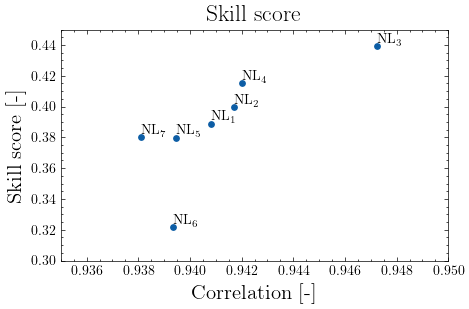

In [9]:
x = correl_matrix["downward_surface_SW_flux"]
y = avg_skill_score.loc[sites,0]
n = x.index
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(x, y, s=15,marker="o")

for i in sites:
    ax.text(x[i], y[i], sites_list[i], verticalalignment='bottom', horizontalalignment='left', color='black')
plt.xlim([0.935,0.95])
plt.ylim([0.3,0.45])
plt.xlabel("Correlation [-]", fontsize=15)
plt.ylabel("Skill score [-]", fontsize=15)
plt.title("Skill score ", fontsize=17)
plt.savefig("Figures/evaluation/corr_irrad_error", dpi=200)